# Test

In [ ]:
!yolo predict task=detect model=yolov8n.pt source="/content/AI_Challenge.jpg"

Ultralytics YOLOv8.2.11 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs

image 1/1 /content/AI_Challenge.jpg: 448x640 5 persons, 1 tv, 77.8ms
Speed: 18.9ms preprocess, 77.8ms inference, 2954.3ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


## Work with data

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import json
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import shutil

## Convert from Publaynet to COCO format
--------- OLD CODE

In [ ]:
!rm -rf /content/drive/MyDrive/data/Doclaynet

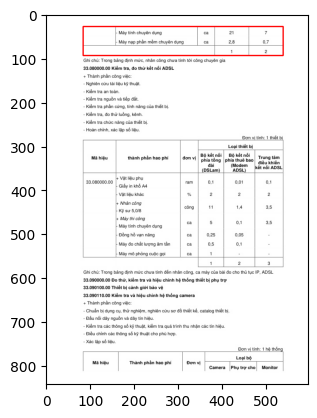

In [ ]:
path = "/content/drive/MyDrive/data/publaynet/train/images"
train_content = json.load(open("/content/drive/MyDrive/data/publaynet/train.json"))
file_name = os.path.join(path, train_content["images"][0]["file_name"])

image = cv2.imread(file_name)
bbox = train_content["annotations"][0]["bbox"]
image = cv2.rectangle(image, (int(bbox[0]), int(bbox[1])), \
                     ((int(bbox[0]) + int(bbox[2])), (int(bbox[1]) + int(bbox[3]))), \
                     color = (255, 0, 0), thickness = 2)

# image = cv2.rectangle(image, (int(bbox[0]), int(bbox[1])), ((int(bbox[0]) + int(bbox[2])), (int(bbox[1]) + int(bbox[3]))), color = (255, 0, 0))
plt.imshow(image)

In [ ]:
path = "/content/drive/MyDrive/data/publaynet/train.json"
train_content = json.load(open(path))
for key in train_content:
  print(key)

print(train_content["images"][0], "\n")
print(train_content["annotations"][0], "\n")
print(train_content["categories"][0], "\n")

images
annotations
categories
{'id': 71744, 'file_name': '44_2020_TTBTTTT_463630_page_157.jpg', 'height': 842, 'width': 596} 

{'bbox': [84.31922611850062, 28.562713797035293, 455.7081821846029, 66.00627137970355], 'bbox_mode': 1, 'category_id': 3, 'image_id': 71744, 'id': 0, 'iscrowd': 0, 'area': 30079.597943228284} 

{'id': 0, 'name': 'text'} 



## Convert from DocLayNet to COCO format

In [ ]:
!mkdir /content/drive/MyDrive/data/DocLayNet_yolo

In [ ]:
# copy train.json from DocLayNet to DocLayNet_yolo

shutil.copy("/content/drive/MyDrive/data/DocLayNet/COCO/train.json",
            "/content/drive/MyDrive/data/DocLayNet_yolo")

# copy val.json from DocLayNet to DocLayNet_yolo

shutil.copy("/content/drive/MyDrive/data/DocLayNet/COCO/val.json",
            "/content/drive/MyDrive/data/DocLayNet_yolo")

'/content/drive/MyDrive/data/DocLayNet_yolo/val.json'

In [ ]:
!rm /content/drive/MyDrive/data/DocLayNet_yolo/val/labels/dataset.yaml

In [ ]:
# !rm -rf /content/drive/MyDrive/data/DocLayNet_yolo/train/images
# !rm -rf /content/drive/MyDrive/data/DocLayNet_yolo/val/images

def copy_images_from_DocLayNet2COCO(train=True):
  COCO_path = "/content/drive/MyDrive/data/DocLayNet_yolo/train" if train \
         else "/content/drive/MyDrive/data/DocLayNet_yolo/val"
  COCO_images_path = os.path.join(COCO_path, "images")

  if not os.path.exists(os.path.join(COCO_path, "images")):
    os.makedirs(os.path.join(COCO_path, "images"))

  DocLayNet_path = "/content/drive/MyDrive/data/DocLayNet/PNG"

  for image_name in os.listdir(os.path.join(COCO_path, "labels")):
    # ex image_name: 01_2022_TTBTTTT_503597_page_0.txt
    image = image_name.replace(".txt", ".png")
    image_path = os.path.join(DocLayNet_path, image)
    if not os.path.exists(os.path.join(COCO_images_path, image)):
      shutil.copy(image_path, COCO_images_path)

# copy_images_from_DocLayNet2COCO()
copy_images_from_DocLayNet2COCO(train=False)

In [ ]:
train_path = "/content/drive/MyDrive/data/DocLayNet_yolo/train"
val_path = "/content/drive/MyDrive/data/DocLayNet_yolo/val"

train_info = "/content/drive/MyDrive/data/DocLayNet_yolo/train.json"
val_info = "/content/drive/MyDrive/data/DocLayNet_yolo/val.json"

if not os.path.exists(os.path.join(train_path, "labels")):
  os.makedirs(os.path.join(train_path, "labels"))

if not os.path.exists(os.path.join(val_path, "labels")):
  os.makedirs(os.path.join(val_path, "labels"))

def normalize(image_size, bbox):
  """
     input box: [x_left, y_left, width, height]
     image_size: [img_width, img_height]
  """
  # return box: [x_center_norm, y_center_norm, width_norm, height_norm]

  x_center = (bbox[0] + bbox[2]/2)/image_size[0]
  y_center = (bbox[1] + bbox[3]/2)/image_size[1]
  width, height = bbox[2]/image_size[0], bbox[3]/image_size[1]

  return [x_center, y_center, width, height]


def write_info_to_file(train=True):
  """
     - write into labels_folder image file (type: .txt)
     - each line in the image file is infor about a bbox in the image:
        category_id x_center y_center width height
  """

  path = train_path if train else val_path
  path_info = train_info if train else val_info
  images_info = json.load(open(path_info))

  mark, num_annots = 0, len(images_info["annotations"])
  annots = images_info["annotations"]

  for image_info in images_info["images"]:
    image_name = image_info["file_name"]
    type_file = image_name[image_name.find('.') :] # type_image: .jpg, .png
    image_txt_file = image_name.replace(type_file, ".txt")
    image_size = [image_info["width"], image_info["height"]]

    with open(image_txt_file, "w") as file:
      for id in range(mark, num_annots):
        if annots[id]["image_id"] == image_info["id"]:
          bbox = annots[id]["bbox"]
          category_id = annots[id]["category_id"]

          norm_box = normalize(image_size, bbox)
          file.write(str(category_id)); file.write(" ")
          for i in range(len(norm_box)):
            if i < len(bbox) - 1:
              file.write(str(norm_box[i])); file.write(" ")
            else:
              file.write(str(norm_box[i])); file.write("\n");
          mark += 1
        else:
          break

In [ ]:
%cd /content/drive/MyDrive/data/DocLayNet_yolo/train/labels

# if len(os.listdir("/content/drive/MyDrive/data/publaynet/train/labels")) != 0:
write_info_to_file()

/content/drive/MyDrive/data/DocLayNet_yolo/train/labels


In [ ]:
%cd /content/drive/MyDrive/data/DocLayNet_yolo/val/labels

# if len(os.listdir("/content/drive/MyDrive/data/publaynet/val/labels")) != 0:
write_info_to_file(train=False)

/content/drive/MyDrive/data/DocLayNet_yolo/val/labels


In [ ]:
"""
  Make yaml file
"""


%cd /content/drive/MyDrive/data/DocLayNet_yolo

!rm dataset.yaml

!echo "train: /content/drive/MyDrive/data/DocLayNet_yolo/train" >> dataset.yaml
!echo "val: /content/drive/MyDrive/data/DocLayNet_yolo/val" >> dataset.yaml
!echo "nc: 8" >> dataset.yaml
!echo "names: ['text', 'title', 'list-item', 'table', 'figure', 'form', 'footnote', 'useless']" >> dataset.yaml

/content/drive/MyDrive/data/DocLayNet_yolo


## Train model

In [ ]:
%cd /content/drive/MyDrive/data/DocLayNet_yolo
# !wget https://github.com/ultralytics/assets/releases/yolov8n.pt

/content/drive/MyDrive/data/DocLayNet_yolo


In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.8/778.8 kB 6.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
from ultralytics import YOLO

model = YOLO("/content/drive/MyDrive/data/DocLayNet_yolo/runs/detect/train15/weights/last.pt")
results = model.train(data = "/content/drive/MyDrive/data/DocLayNet_yolo/dataset.yaml")

Ultralytics YOLOv8.2.25 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3007208 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/MyDrive/data/DocLayNet_yolo/val/labels.cache... 1347 images, 1 backgrounds, 1 corrupt: 100%|██████████| 1348/1348 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/MyDrive/data/DocLayNet_yolo/val/images/25_2016_NDCP_308264_page_15.png: ignoring corrupt image/label: cannot identify image file '/content/drive/MyDrive/data/DocLayNet_yolo/val/images/25_2016_NDCP_308264_page_15.png'



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [12:45<00:00,  9.01s/it]


                   all       1347      18421      0.806      0.567      0.649      0.557
                  text       1347       4598       0.77      0.726      0.805      0.727
                 title       1347       3224      0.802       0.81      0.857      0.735
             list-item       1347       9503      0.839      0.922      0.902      0.817
                 table       1347        586      0.885      0.968      0.967      0.949
                figure       1347        130      0.925      0.569      0.739      0.556
                  form       1347         80      0.884       0.38      0.637      0.477
              footnote       1347         78          1          0     0.0394     0.0184
               useless       1347        222      0.341      0.162      0.242      0.172
Speed: 3.0ms preprocess, 196.9ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/val


# Inference

In [ ]:
%cd /content/drive/MyDrive/data/DocLayNet_yolo

!echo "train: /content/drive/MyDrive/data/DocLayNet_yolo/train" >> infer_train.yaml
# !echo "val: /content/drive/MyDrive/data/DocLayNet_yolo/train" >> infer_train.yaml
# !echo "nc: 8" >> infer_train.yaml
# !echo "names: ['text', 'title', 'list-item', 'table', 'figure', 'form', 'footnote', 'useless']" >> infer_train.yaml

/content/drive/MyDrive/data/DocLayNet_yolo


In [ ]:
results = model.val(data = "/content/drive/MyDrive/data/DocLayNet_yolo/infer_train.yaml")

Ultralytics YOLOv8.2.25 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)


val: Scanning /content/drive/MyDrive/data/DocLayNet_yolo/train/labels.cache... 2875 images, 5 backgrounds, 0 corrupt: 100%|██████████| 2875/2875 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/data/DocLayNet_yolo/train/images/09_2022_TTBTTTT_521625_page_0.png: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/data/DocLayNet_yolo/train/images/Nguyen_ly_quan_tri_page_7.png: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [24:33<00:00,  8.19s/it]


                   all       2875      38731      0.804      0.842      0.875      0.779
                  text       2875      10612      0.761       0.92      0.929      0.822
                 title       2875       7097      0.776      0.919      0.933      0.848
             list-item       2875      18378      0.824      0.984      0.958      0.892
                 table       2875       1922      0.948      0.988      0.993       0.98
                figure       2875        349      0.904      0.946      0.973      0.905
                  form       2875        119      0.796      0.899      0.904      0.766
              footnote       2875         48      0.662      0.204       0.43      0.329
               useless       2875        206      0.759      0.874      0.881      0.687
Speed: 4.0ms preprocess, 196.1ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/val3
